# Analysis 1h - Run simulations, visualize phase space and plot scatter plots to intuitively see correlations

## Includes linear stability analysis at fixed points

## Uses a differentiable equation as opposed to a discrete-time model

#### Taku Ito
#### 9/5/2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
import os
os.sys.path.append('../')
import BalloonWindkessel as bw
plt.style.use('ggplot')
sns.set_style('white')

# 1.0 Define functions

Let $x_1$ be an excitatory neuron. Let $x_2$ be an inhibitory neuron. Define $w_ij$ to be the weight from neuron $x_i$ to $x_j$.

To identify the rate of change for the firing rates for these neuronal populations, we have

$$\tau_1 \frac{dx_1}{dt} = -x_1 + f\Big( w_{11} x_1 + w_{21} x_2 + b_1 + s_1 \Big) \qquad \qquad (2)$$

$$\tau_2 \frac{dx_2}{dt} = -x_2 + f\Big( w_{12} x_1 + w_{22} x_2 + b_2 + s_2 \Big) \qquad \qquad (3)$$

Where $f(x)$ refers to the nonlinear function defined above, $\tau_i$ refers to the time constant of neuron $i$, and $s_i$ is the gain on neuron $i$.


# Need to fix below equations

### 2.1 - Phase Portraits and Nullclines for $x_1$ and $x_2$ 

Mathematical formula for $x_1$ nullcline:
$$ x_2 = \frac{f^{-1} ( -x_1 ) - w_{11} x_1 - b_1 - s_1}{w_{21}} $$

Mathematical formula for $x_2$ nullcline:
$$ x_1 = \frac{f^{-1} ( -x_2 ) - w_{22} x_2 - b_2 - s_2}{-w_{12}} $$

## 2.2 - Jacobian matrix

The *Jacobian* $J$ is defined by
$$
 J = \left( \begin{array}{cc}
\big(-1 + f'(w_{11} x_1 + w_{21}x_2 + b_1 + s_1)\big) \frac{1}{\tau_1} & \big(f'( w_{11} x_1 + w_{21} x_2 + b_1 + s_1)\big) \frac{1}{\tau_1} \\
\big( f'(w_{22} x_2 + w_{12} x_1 + b_2 + s_2)\big)\frac{1}{\tau_2} & \big(-1 + f'(w_{22} x_2 + w_{12} x_1 + b_2 + s_2)\big)\frac{1}{\tau_2} \end{array} \right) $$

In [2]:
def sigmoid(x):
#     return np.tanh(x)
    return 1/(1+np.exp(-.5*x))

def dxdtSigmoid(x):
    return np.exp(x)/((np.exp(x)+1)**2)
#     return x - np.log(np.exp(x) + 1)

def invsigmoid(x):
    return 2*np.log((x)/(1-(x)))


def runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1):
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    I2[0] = xinit2
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+w21*I2[i-1]+b1+d1[i-1]+s1[i-1]) 
        i1k1 = i1k1/tau1
        i2k1 = -I2[i-1] + sigmoid(w22*I2[i-1]+w12*I1[i-1]+b2+d2[i-1]+s2[i-1]) 
        i2k1 = i2k1/tau2
        
        i1a = I1[i-1] + i1k1*dt
        i2a = I2[i-1] + i2k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+w21*i2a+b1+d1[i]+s1[i])
        i1k2 = i1k2/tau1
        i2k2 = -i2a + sigmoid(w22*i2a+w12*i1a+b2+d2[i]+s2[i]) 
        i2k2 = i2k2/tau2
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        I2[i] = I2[i-1] + dt*((i2k1+i2k2)/2)
        
    return I1[25:], I2[25:]

def findFP(w11,w12,w22,w21,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1):
    """
    Finds the fixed point of the model for a particular parameter regime
    """
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit1
    I2[0] = xinit2
    
    for i in range(1,t):
        i1k1 = -I1[i-1] + sigmoid(w11*I1[i-1]+w21*I2[i-1]+b1+s1) 
        i1k1 = i1k1/tau1
        i2k1 = -I2[i-1] + sigmoid(w22*I2[i-1]+w12*I1[i-1]+b2+s2) 
        i2k1 = i2k1/tau2
        
        i1a = I1[i-1] + i1k1*dt
        i2a = I2[i-1] + i2k1*dt
        
        i1k2 = -i1a + sigmoid(w11*i1a+w21*i2a+b1+s1)
        i1k2 = i1k2/tau1
        i2k2 = -i2a + sigmoid(w22*i2a+w12*i1a+b2+s2) 
        i2k2 = i2k2/tau2
        
        I1[i] = I1[i-1] + dt*((i1k1+i1k2)/2)
        I2[i] = I2[i-1] + dt*((i2k1+i2k2)/2)
        
        if I1[i] == I1[i-1] and I2[i] == I2[i-1]: 
            I1fp = I1[i] 
            I2fp = I2[i]
            break        
        
    return I1fp, I2fp

def computeJacobian(fpx1,fpx2,w11,w22,w12,w21,b1,b2,s1,s2,tau1,tau2):
    j11 = (-1 + dxdtSigmoid(w11*fpx1+w21*fpx2+b1+s1))/tau1
    j12 = (dxdtSigmoid(w11*fpx1+w21*fpx2+b1+s1))/tau1
    j21 = (dxdtSigmoid(w22*fpx2+w12*fpx1+b2+s2))/tau2
    j22 = (-1 + dxdtSigmoid(w22*fpx2+w12*fpx1+b2+s2))/tau2
    Jacobian = np.zeros((2,2))
    Jacobian[0,0] = j11
    Jacobian[0,1] = j12
    Jacobian[1,0] = j21
    Jacobian[1,1] = j22
    return Jacobian


def nullclineI1(w11,w21,d1,I1,b1,s1,b2):
    pos_ind = np.where(I1>0)[0]
    invx1 = invsigmoid(I1[pos_ind])
    nI1 = (invx1 - w11*I1[pos_ind] - b1 - s1)/w21
    I1 = I1[pos_ind]
    return nI1, I1

def nullclineI2(w22,w12,d2,I2,b2,s2,b1):
    pos_ind = np.where(I2>0)[0]
    invx2 = invsigmoid(I2[pos_ind])
    nI2 = (invx2 - w22*I2[pos_ind] - b2 - s2)/w12
    I2 = I2[pos_ind]
    return nI2, I2



## Parameters

In [3]:
# Set connectivity weights
w11 = 2
w22 = 2
w12 = 4
w21 = 4


# Set biases
b1 = -3
b2 = -3
# Set time constants
tau1 = 0.1
tau2 = 0.1

# 2.0 Run simulations

## 2.1 De-activate both regions

/Users/tito/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


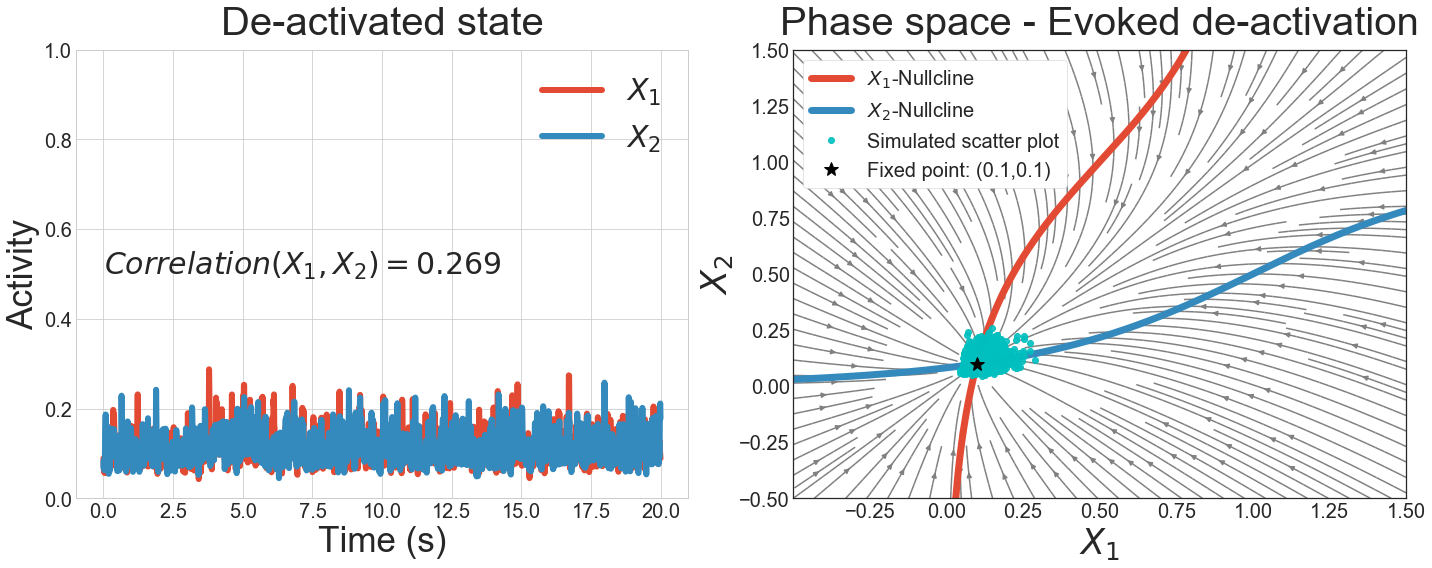

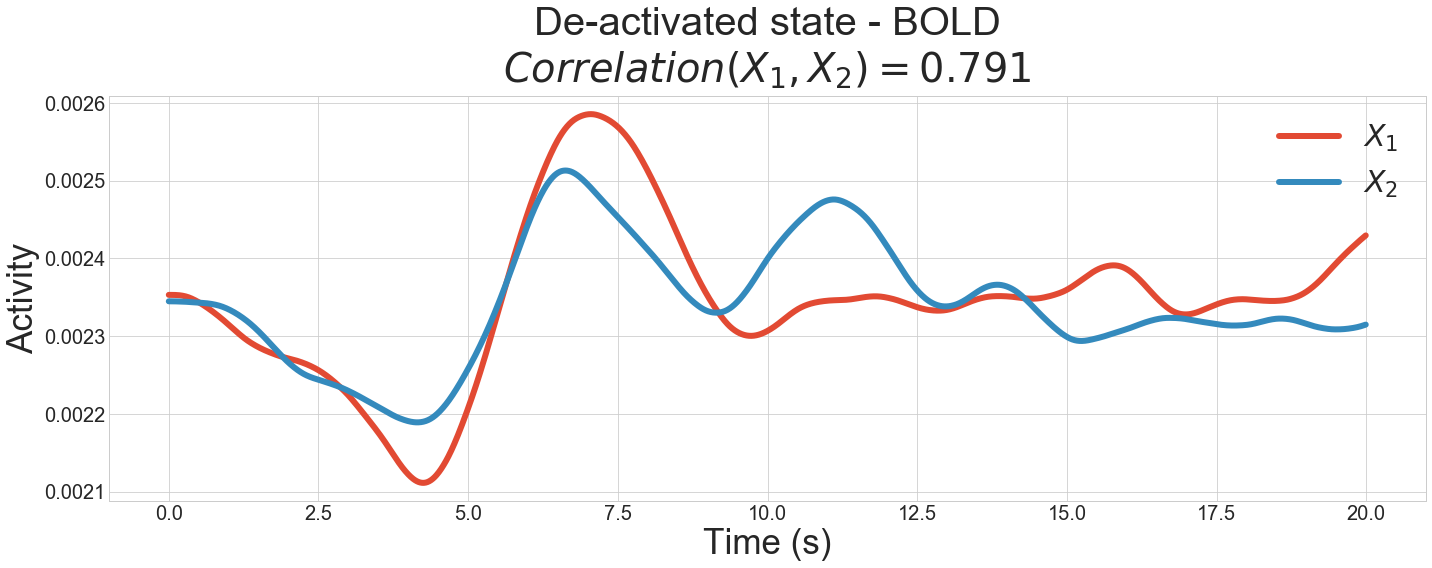

In [4]:
# Set n timepoints
t = 2025

# d1 = np.zeros((t,))
# d2 = np.zeros((t,))
d1 = np.random.normal(0,1.0,(t,))
d2 = np.random.normal(0,1.0,(t,))
s1 = -2
s2 = -2
s1vec = np.ones((t,))*s1
s2vec = np.ones((t,))*s2
# Set stimulation only to region 1
# s1[stimOnset:stimOffset] = 0

## Identify fixed point
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2,dt=.1)

# Set initial conditions
xinit1 = I1fp
xinit2 = I2fp

#####
## Run simulations
I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2)
# Calculate correlations
rI1I2, p = stats.pearsonr(I1,I2)

#####
## Calculate nullclines
I1_sort = np.arange(-5,100,.001)
I2_sort = np.arange(-5,100,.001)

d = 0
nI1,xI1 = nullclineI1(w11,w21,d,I1_sort,b1,s1,b2)
nI2,yI2 = nullclineI2(w22,w12,d,I2_sort,b2,s2,b1)


# Generate plots
plt.figure(figsize=(20,8))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Plot
sns.set_style('whitegrid')
plt.subplot(121)
plt.plot(range(len(I1)),I1,label='$X_1$',linewidth=6)
plt.plot(range(len(I2)),I2,label='$X_2$',linewidth=6)
plt.xlabel('Time (s)',fontsize=35)
plt.ylabel('Activity',fontsize=35)
plt.title('De-activated state', fontsize=40, y=1.02)
plt.annotate(xy=[0.5,.5], s='$Correlation(X_1, X_2) = ' + str(round(rI1I2,3)) + '$',fontsize=30)
plt.xticks(np.arange(0,len(I1)+250,250),np.arange(0,len(I1)+250,250)*.01)
#plt.title('De-activated state', fontsize=35,y=1.02)
lgd = plt.legend(loc=1,prop={'size': 30})
plt.ylim([0,1.0])
plt.tight_layout()

xscalemin = -0.5
xscalemax = 1.5
yscalemin = -0.5
yscalemax = 1.5
vectorfield=True
sns.set_style('white')
plt.subplot(122)
plt.title('Phase space - Evoked de-activation',fontsize=40, y=1.02)
plt.plot(xI1,nI1,label='$X_1$-Nullcline',linewidth=7)
plt.plot(nI2,yI2,label='$X_2$-Nullcline',linewidth=7)
plt.plot(I1,I2,'oc',label='Simulated scatter plot',alpha=.9, linewidth=5)
plt.plot(I1fp,I2fp,'*',color='k',markersize=15, label='Fixed point: (' + str(round(I1fp,2)) + ',' + str(round(I2fp,2)) + ')')


if vectorfield:
    Y, X = np.mgrid[yscalemin:yscalemax:100j, xscalemin:xscalemax:100j]
    V = (-X + sigmoid(w11*X+w21*Y+b1+s1))/tau1
    U = (-Y + sigmoid(w22*Y+w12*X+b2+s2))/tau2
    plt.streamplot(X, Y, V, U, color='0.5', density=2)
    
plt.xlabel('$X_1$',fontsize=35)
plt.ylabel('$X_2$',fontsize=35)
plt.ylim([yscalemin,yscalemax])
plt.xlim([xscalemin,xscalemax])
plt.xticks(np.arange(-.25,1.7,.25))
lgd = plt.legend(loc=2,prop={'size': 20},frameon=True,facecolor='white',framealpha=1.0)
# frame = lgd.get_frame()
# frame.set_facecolor('green')
plt.tight_layout()
# plt.tight_layout(rect=[0, 0.03, 1, 0.8])
plt.savefig('DeactivatedState.pdf',bbox_inches='tight')


## Transform neural activity to fMRI BOLD signal using Balloon-Windkessel model (Friston et al., 2003)
sns.set_style('whitegrid')
plt.figure(figsize=(20,8))
BOLD1 = bw.balloonWindkessel(I1,sampling_rate=0.01)[0]
BOLD2 = bw.balloonWindkessel(I2,sampling_rate=0.01)[0]
rBOLD12, p = stats.pearsonr(BOLD1[0],BOLD2[0])
plt.plot(range(BOLD1.shape[1]),BOLD1.T,label='$X_1$',linewidth=6)
plt.plot(range(BOLD2.shape[1]),BOLD2.T,label='$X_2$',linewidth=6)
plt.xlabel('Time (s)',fontsize=35)
plt.ylabel('Activity',fontsize=35)
plt.title('De-activated state - BOLD\n$Correlation(X_1, X_2) = ' + str(round(rBOLD12,3)) + '$', fontsize=40, y=1.02)
plt.xticks(np.arange(0,len(BOLD1[0])+250,250),np.arange(0,len(BOLD1[0])+250,250)*.01)
lgd = plt.legend(loc=1,prop={'size': 30})
plt.tight_layout()

### Linear stability analysis using Jacobian at Fixed Point

In [5]:
# Calculate fixed points
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2)
print 'Fixed point: (', I1fp, I2fp, ')'

# Calculate eigenvectors at fixed points
J = computeJacobian(I1fp,I2fp,w11,w22,w12,w21,b1,b2,s1,s2,tau1,tau2)
eigenval, eigenvec = np.linalg.eig(J)
print 'Eigenvalues:', eigenval[0], 'and', eigenval[1]
proportion = eigenval[0]/eigenval[1]
print 'Eigenvalue ratio:', proportion

Fixed point: ( 0.09965853612443829 0.09965853612443829 )
Eigenvalues: -9.760851847007695 and -9.999999999999998
Eigenvalue ratio: 0.9760851847007697


## 2.3 Run intrinsic activity  (s1 = 0; s2 = 0)

/Users/tito/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


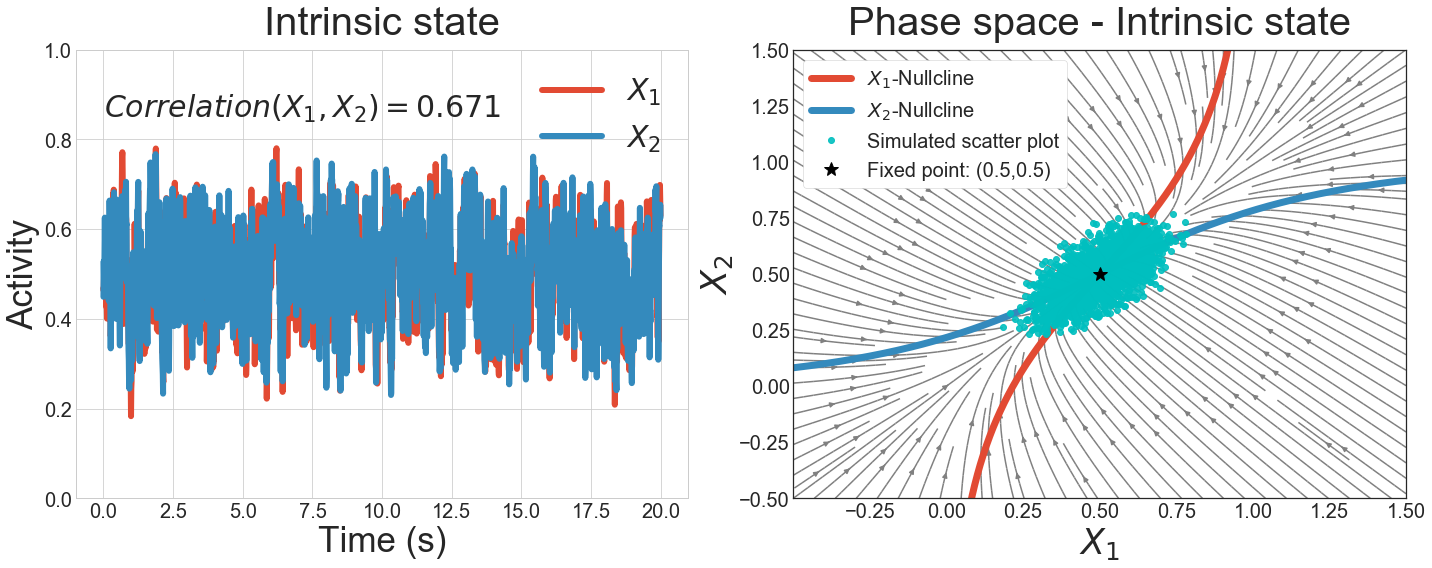

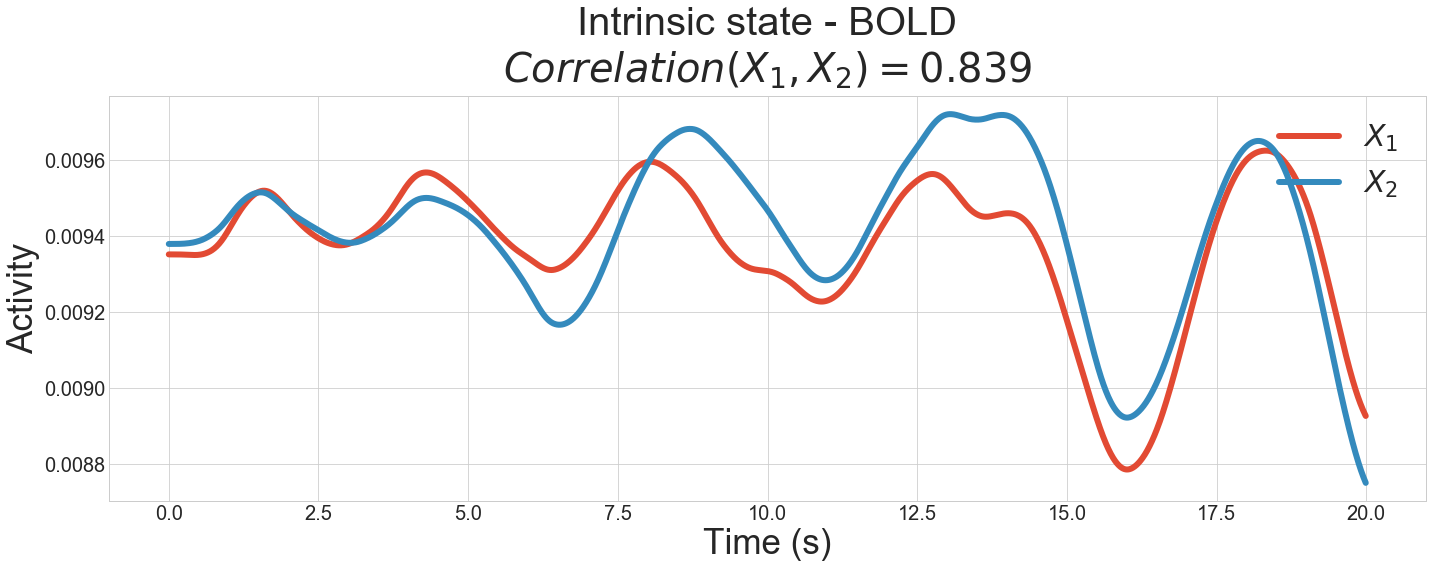

In [6]:
# Set n timepoints
t = 2025

# d1 = np.zeros((t,))
# d2 = np.zeros((t,))
d1 = np.random.normal(0,1.0,(t,))
d2 = np.random.normal(0,1.0,(t,))
s1 = 0
s2 = 0
s1vec = np.ones((t,))*s1
s2vec = np.ones((t,))*s2
# Set stimulation only to region 1
# s1[stimOnset:stimOffset] = 0

## Identify fixed point
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2,dt=.1)

# Set initial conditions
xinit1 = I1fp
xinit2 = I2fp

#####
## Run simulations
I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2)

#####
## Run simulations
I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2)
# Calculate correlations
rI1I2, p = stats.pearsonr(I1,I2)

#####
## Calculate nullclines
I1_sort = np.arange(-5,100,.001)
I2_sort = np.arange(-5,100,.001)

d = 0
nI1,xI1 = nullclineI1(w11,w21,d,I1_sort,b1,s1,b2)
nI2,yI2 = nullclineI2(w22,w12,d,I2_sort,b2,s2,b1)



# Generate plots
plt.figure(figsize=(20,8))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Plot
sns.set_style('whitegrid')
plt.subplot(121)
plt.plot(range(len(I1)),I1,label='$X_1$',linewidth=6)
plt.plot(range(len(I2)),I2,label='$X_2$',linewidth=6)
plt.xlabel('Time (s)',fontsize=35)
plt.ylabel('Activity',fontsize=35)
plt.title('Intrinsic state', fontsize=40,y=1.02)
plt.xticks(np.arange(0,len(I1)+250,250),np.arange(0,len(I1)+250,250)*.01)
plt.annotate(xy=[0.5,.85], s='$Correlation(X_1, X_2) = ' + str(round(rI1I2,3)) + '$',fontsize=30)
#plt.title('De-activated state', fontsize=35,y=1.02)
lgd = plt.legend(loc=1,prop={'size': 30})
plt.ylim([0,1.0])
plt.tight_layout()

xscalemin = -0.5
xscalemax = 1.5
yscalemin = -0.5
yscalemax = 1.5
vectorfield=True
sns.set_style('white')
plt.subplot(122)
plt.title('Phase space - Intrinsic state',fontsize=40,y=1.02)
plt.plot(xI1,nI1,label='$X_1$-Nullcline',linewidth=7)
plt.plot(nI2,yI2,label='$X_2$-Nullcline',linewidth=7)
plt.plot(I1,I2,'oc',label='Simulated scatter plot',alpha=.9, linewidth=5)
plt.plot(I1fp,I2fp,'*',color='k',markersize=15, label='Fixed point: (' + str(round(I1fp,2)) + ',' + str(round(I2fp,2)) + ')')

if vectorfield:
    Y, X = np.mgrid[yscalemin:yscalemax:100j, xscalemin:xscalemax:100j]
    V = (-X + sigmoid(w11*X+w21*Y+b1+s1))/tau1
    U = (-Y + sigmoid(w22*Y+w12*X+b2+s2))/tau2
    plt.streamplot(X, Y, V, U, color='0.5', density=2)
    
plt.xlabel('$X_1$',fontsize=35)
plt.ylabel('$X_2$',fontsize=35)
plt.ylim([yscalemin,yscalemax])
plt.xlim([xscalemin,xscalemax])
plt.xticks(np.arange(-.25,1.7,.25))
lgd = plt.legend(loc=2,prop={'size': 20},frameon=True,facecolor='white',framealpha=1.0)
plt.tight_layout()
plt.savefig('IntrinsicState.pdf',bbox_inches='tight')

## Transform neural activity to fMRI BOLD signal using Balloon-Windkessel model (Friston et al., 2003)
sns.set_style('whitegrid')
plt.figure(figsize=(20,8))
BOLD1 = bw.balloonWindkessel(I1,sampling_rate=0.01)[0]
BOLD2 = bw.balloonWindkessel(I2,sampling_rate=0.01)[0]
rBOLD12, p = stats.pearsonr(BOLD1[0],BOLD2[0])
plt.plot(range(BOLD1.shape[1]),BOLD1.T,label='$X_1$',linewidth=6)
plt.plot(range(BOLD2.shape[1]),BOLD2.T,label='$X_2$',linewidth=6)
plt.xlabel('Time (s)',fontsize=35)
plt.ylabel('Activity',fontsize=35)
plt.title('Intrinsic state - BOLD\n$Correlation(X_1, X_2) = ' + str(round(rBOLD12,3)) + '$', fontsize=40, y=1.02)
plt.xticks(np.arange(0,len(BOLD1[0])+250,250),np.arange(0,len(BOLD1[0])+250,250)*.01)
lgd = plt.legend(loc=1,prop={'size': 30})
plt.tight_layout()
plt.savefig('Analysis1i_IntrinsicStateBOLD.pdf')

### Linear stability analysis

In [7]:
# Calculate fixed points
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2)
print 'Fixed point: (', I1fp, I2fp, ')'

# Calculate eigenvectors at fixed points
J = computeJacobian(I1fp,I2fp,w11,w22,w12,w21,b1,b2,s1,s2,tau1,tau2)
eigenval, eigenvec = np.linalg.eig(J)
print 'Eigenvalues:', eigenval[0], 'and', eigenval[1]
proportion = eigenval[0]/eigenval[1]
print 'Eigenvalue ratio:', proportion

Fixed point: ( 0.4999999999999998 0.4999999999999998 )
Eigenvalues: -5.0 and -10.0
Eigenvalue ratio: 0.5


## 2.4 Activate both regions and decrease correlations (s1 = 2; s2 = 2)

/Users/tito/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


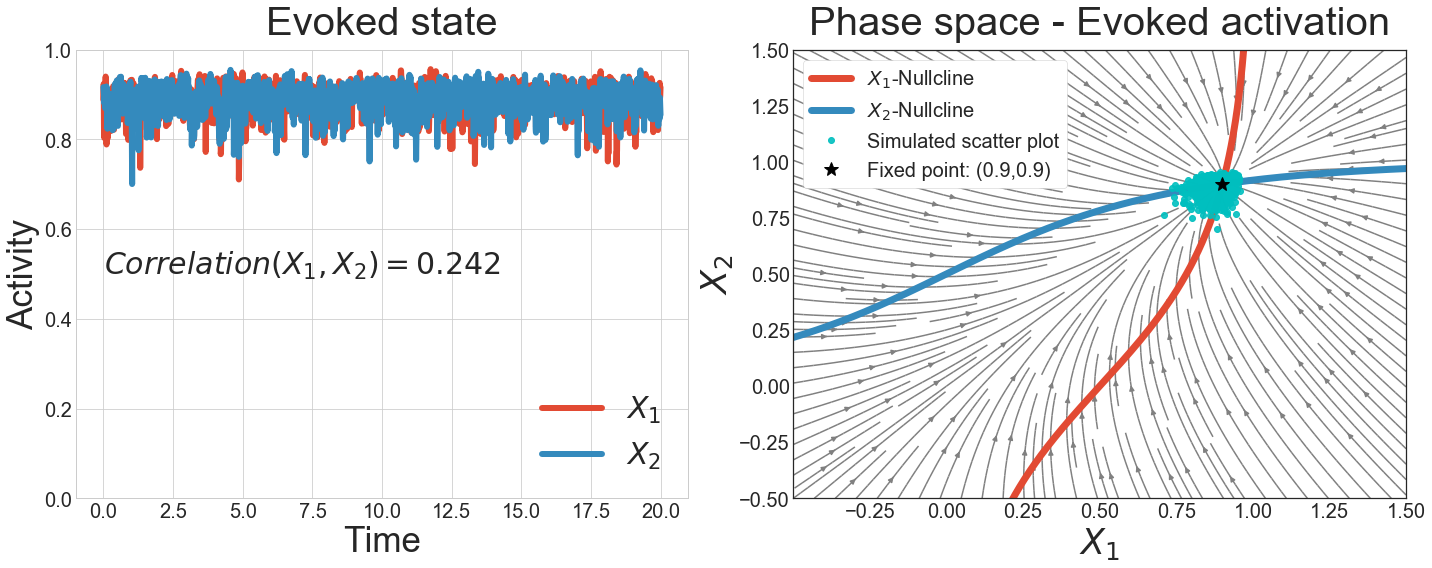

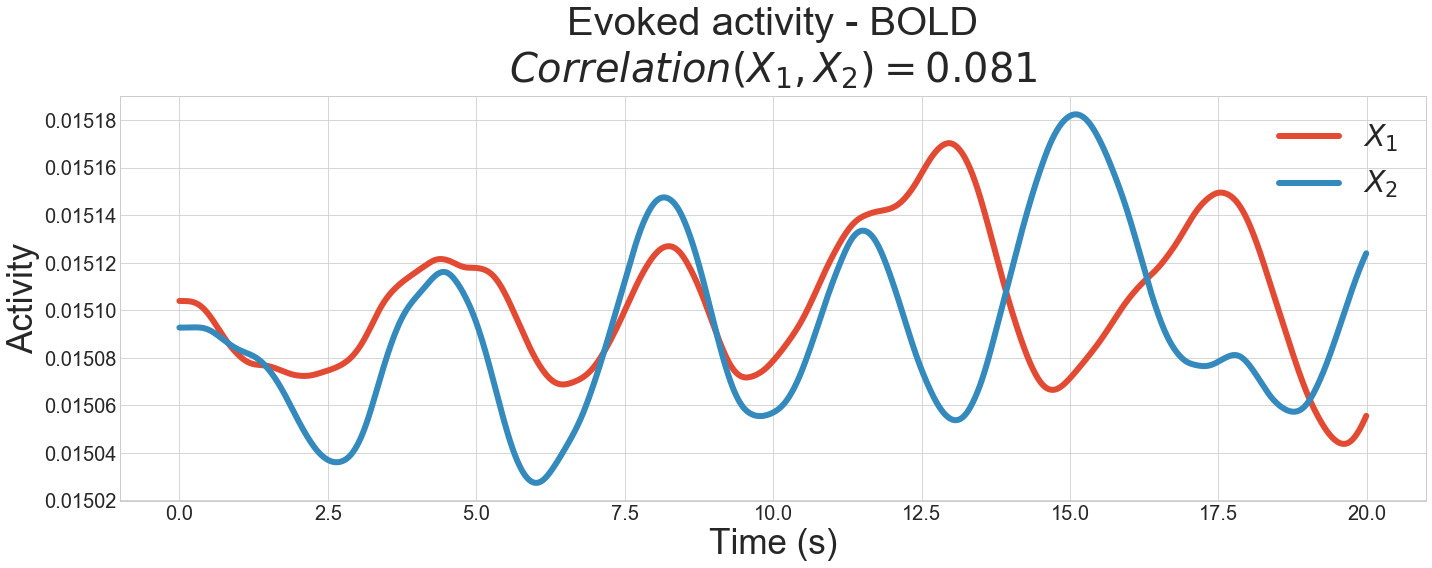

In [8]:
# Set n timepoints
t = 2025

# d1 = np.zeros((t,))
# d2 = np.zeros((t,))
d1 = np.random.normal(0,1.0,(t,))
d2 = np.random.normal(0,1.0,(t,))
s1 = 2
s2 = 2
s1vec = np.ones((t,))*s1
s2vec = np.ones((t,))*s2
# Set stimulation only to region 1
# s1[stimOnset:stimOffset] = 0


## Identify fixed point
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,t,xinit1,xinit2,tau1,tau2,dt=.1)

# Set initial conditions
xinit1 = I1fp
xinit2 = I2fp

#####
## Run simulations
I1, I2 = runSim(w11,w12,w22,w21,d1,d2,b1,b2,s1vec,s2vec,t,xinit1,xinit2,tau1,tau2)
# Calculate correlations
rI1I2, p = stats.pearsonr(I1,I2)

#####
## Calculate nullclines
I1_sort = np.arange(-5,100,.001)
I2_sort = np.arange(-5,100,.001)

d = 0
nI1,xI1 = nullclineI1(w11,w21,d,I1_sort,b1,s1,b2)
nI2,yI2 = nullclineI2(w22,w12,d,I2_sort,b2,s2,b1)



# Generate plots
plt.figure(figsize=(20,8))
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Plot
sns.set_style('whitegrid')
plt.subplot(121)
plt.plot(range(len(I1)),I1,label='$X_1$',linewidth=6)
plt.plot(range(len(I2)),I2,label='$X_2$',linewidth=6)
plt.xlabel('Time',fontsize=35)
plt.ylabel('Activity',fontsize=35)
plt.title('Evoked state', fontsize=40,y=1.02)
plt.annotate(xy=[0.5,.5], s='$Correlation(X_1, X_2) = ' + str(round(rI1I2,3)) + '$',fontsize=30)
plt.xticks(np.arange(0,len(I1)+250,250),np.arange(0,len(I1)+250,250)*.01)
#plt.title('De-activated state', fontsize=35,y=1.02)
lgd = plt.legend(loc=4,prop={'size': 30})
plt.ylim([0,1.0])
plt.tight_layout()

xscalemin = -0.5
xscalemax = 1.5
yscalemin = -0.5
yscalemax = 1.5
vectorfield=True
sns.set_style('white')
plt.subplot(122)
plt.title('Phase space - Evoked activation',fontsize=40,y=1.02)
plt.plot(xI1,nI1,label='$X_1$-Nullcline',linewidth=7)
plt.plot(nI2,yI2,label='$X_2$-Nullcline',linewidth=7)
plt.plot(I1,I2,'oc',label='Simulated scatter plot',alpha=.9, linewidth=5)
plt.plot(I1fp,I2fp,'*',color='k',markersize=15, label='Fixed point: (' + str(round(I1fp,2)) + ',' + str(round(I2fp,2)) + ')')


if vectorfield:
    Y, X = np.mgrid[yscalemin:yscalemax:100j, xscalemin:xscalemax:100j]
    V = (-X + sigmoid(w11*X+w21*Y+b1+s1))/tau1
    U = (-Y + sigmoid(w22*Y+w12*X+b2+s2))/tau2
    plt.streamplot(X, Y, V, U, color='0.5', density=2)
    
plt.xlabel('$X_1$',fontsize=35)
plt.ylabel('$X_2$',fontsize=35)
plt.ylim([yscalemin,yscalemax])
plt.xlim([xscalemin,xscalemax])
plt.xticks(np.arange(-.25,1.7,.25))
lgd = plt.legend(loc=2,prop={'size': 20},frameon=True,facecolor='white',framealpha=1.0)
plt.tight_layout()
plt.savefig('EvokedState.pdf',bbox_inches='tight')

## Transform neural activity to fMRI BOLD signal using Balloon-Windkessel model (Friston et al., 2003)
sns.set_style('whitegrid')
plt.figure(figsize=(20,8))
BOLD1 = bw.balloonWindkessel(I1,sampling_rate=0.01)[0]
BOLD2 = bw.balloonWindkessel(I2,sampling_rate=0.01)[0]
rBOLD12, p = stats.pearsonr(BOLD1[0],BOLD2[0])
plt.plot(range(BOLD1.shape[1]),BOLD1.T,label='$X_1$',linewidth=6)
plt.plot(range(BOLD2.shape[1]),BOLD2.T,label='$X_2$',linewidth=6)
plt.xlabel('Time (s)',fontsize=35)
plt.ylabel('Activity',fontsize=35)
plt.title('Evoked activity - BOLD\n$Correlation(X_1, X_2) = ' + str(round(rBOLD12,3)) + '$', fontsize=40, y=1.02)
plt.xticks(np.arange(0,len(BOLD1[0])+250,250),np.arange(0,len(BOLD1[0])+250,250)*.01)
lgd = plt.legend(loc=1,prop={'size': 30})
plt.tight_layout()
plt.savefig('Analysis1i_EvokedStateBOLD.pdf')


### Linear stability analysis

In [9]:
# Calculate fixed points
xinit1 = 0
xinit2 = 0
I1fp, I2fp = findFP(w11,w12,w22,w21,b1,b2,s1,s2,10000,xinit1,xinit2,tau1,tau2)
print 'Fixed point: (', I1fp, I2fp, ')'

# Calculate eigenvectors at fixed points
J = computeJacobian(I1fp,I2fp,w11,w22,w12,w21,b1,b2,s1,s2,tau1,tau2)
eigenval, eigenvec = np.linalg.eig(J)
print 'Eigenvalues:', eigenval[0], 'and', eigenval[1]
proportion = eigenval[0]/eigenval[1]
print 'Eigenvalue ratio:', proportion

Fixed point: ( 0.9003414638755616 0.9003414638755616 )
Eigenvalues: -9.760851847007693 and -10.0
Eigenvalue ratio: 0.9760851847007693


___